In [1]:
import os
import requests
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
use_GPU = False

In [4]:
if use_GPU:
    if torch.backends.mps.is_available():
        device = torch.device("mps")
        print ("MPS device available.")
    else:
        device = torch.device("cpu")
        print ("MPS device not found. Using CPU.")
else:
    device = torch.device("cpu")
    print ("Using CPU.")

Using CPU.


# Reading the data

In [5]:
# Downloading the file
filepath = '../data/input.txt'
if not os.path.exists(filepath):
    data_url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'
    with open(filepath, 'w', encoding='utf-8') as f:
        f.write(requests.get(data_url).text)

In [6]:
# Reading the file
with open(filepath) as f:
    raw_text = f.read()

print(raw_text[:100])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


In [7]:
print(len(raw_text))

1115394


In [8]:

# ordered list of all characters in the corpus
vocab = sorted(list(set(raw_text)))
vocab_size = len(vocab)
print(f'vocab_size: {vocab_size}')

# dictionaries to convert chars to ints, and viceversa
itos = {i:v for i,v in enumerate(vocab)}
stoi = {v:i for i,v in enumerate(vocab)}

# functions to tokenize sequences of arbitrary length
encode = lambda x : [stoi[s] for s in x]
decode = lambda x : ''.join([itos[i] for i in x])

hello_encoded = encode('hello!')
hello_decoded = decode(hello_encoded)
print(f'encode.    hello   => {hello_encoded}')
print(f'decode.    {hello_encoded}   => {hello_decoded}')

vocab_size: 65
encode.    hello   => [46, 43, 50, 50, 53, 2]
decode.    [46, 43, 50, 50, 53, 2]   => hello!


In [9]:
# Tokenizing the text an creating a numerical tensor
token_text = torch.tensor(encode(raw_text))
token_text.shape

torch.Size([1115394])

In [10]:
# Splitting data in train, val
train_size = int(0.9 * len(token_text))
data_train = token_text[:train_size]
data_val = token_text[train_size:]
print(data_train.shape, data_val.shape)

torch.Size([1003854]) torch.Size([111540])


In [11]:
data_train = data_train.to(device)

In [12]:
# Preparing training batches

torch.manual_seed(1337)

batch_size = 4   # the number of sample processed in the same batch
block_size = 8   # the length of the sequence of character used by the model to predict the next character

def get_batch(data, batch_size, block_size, device):

    # generating the start index of  batch_size independent samples
    idx = torch.randint(len(data)-block_size, (batch_size,), device=device)

    # extracting the xi, each having block_size elements
    x = torch.stack([data[i:i+block_size] for i in idx])
    #print(x.device)

    # extracting the yi, the next characters
    y = torch.stack([data[i+1:i+1+block_size] for i in idx]) 

    # moving tensors to device
    #x, y = x.to(device), y.to(device)
    #x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
    
    return x, y

x_train, y_train = get_batch(data_train, batch_size, block_size, device)

In [13]:
x_train.device

device(type='cpu')

In [14]:
# Preparing the validation data
X_val, y_val = get_batch(data_val, data_val.shape[0], block_size, device)

In [15]:
print(x_train.shape)
print(x_train)
print()
print(y_train.shape)
print(y_train)

torch.Size([4, 8])
tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])

torch.Size([4, 8])
tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]])


# Creating models

## Bigram model


In [16]:
# Predicts next character using only the previous character

class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()

        # A table mapping the index of each character, to the logits distribution of the next character
        # The element E[i,j] represent the logit associated to next character being j, when the current 
        # character is i
        self.E = nn.Embedding(vocab_size, vocab_size)

    def forward(self, X, y=None):

        # extracting the logits of the next character, for each character in the input
        # The shape of the input is (batch_size, block_size)
        # The shape of the output is (batch_size, block_size, vocab_size)
        logits = self.E(X)

        # computing loss, only when a target y is provided
        if y is not None:
            # reshaping logits, and target to match the expected shapes of the cross_entropy function
            batch_size, block_size, vocab_size = logits.shape
            logits = logits.view((batch_size*block_size, vocab_size))
            y = y.view(batch_size*block_size)
            
            # computing the loss
            loss = F.cross_entropy(logits, y)
        else:
            loss = None

        return logits, loss

    def generate(self, X, max_length=100):

        for i in range(max_length):
            # performing a forward pass
            logits, loss = self.forward(X)
    
            # condsidering only the last character of each sequence
            logits = logits[:, -1, :]
    
            # computing probs, from the logits
            probs = logits.softmax(dim=-1)
    
            # sampling from the probability distributions
            new_element = torch.multinomial(probs, 1)
    
            # attaching the new elements to the context
            X = torch.concat((X, new_element), axis=1)

        # Decoding the generated sequences
        res = [decode(X[i].tolist()) for i in range(X.shape[0]) ]

        return res

In [17]:
m = BigramLanguageModel(vocab_size)
logits, loss = m(x_train, y_train)
logits.shape, loss

(torch.Size([32, 65]), tensor(4.6161, grad_fn=<NllLossBackward0>))

In [18]:
# Generating sequence from UNTRAINED model

# creating initial context
context = torch.zeros((1, 1)).int()

# generating sequence of arbitrary length 
res = m.generate(context, max_length=100)

print(res[0])


i,rrPAUpt$ZA.!v!FwnToT;jo
bn-lx:co$SfhlLPXWEuxJXopRjyXIKFlCjFCGgX$'PV-G;VDrMCCsT?WakygEz3kncyDvwhbNr


In [21]:
# Training a model with Adam Optimizer
optimizer = torch.optim.Adam(m.parameters(), lr=10**(-3))

print('TRAINING')
steps = 100000
for i in range(steps):

    # generating a random batch
    X_b, y_b = get_batch(data_train, batch_size, block_size, device)

    # forward pass
    logits, loss = m(X_b, y_b)

    # bacward pass
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    # printing at 10% intervals
    if i % int(steps / 10) == 0:
        print(loss.item())

print()
print('VALIDATION')
logits, loss = m(X_val, y_val)
print(loss)

TRAINING
4.9710493087768555
2.2749061584472656
2.069427251815796
2.72166109085083
2.6071584224700928
2.0997016429901123
2.4455082416534424
2.4198312759399414
2.3851704597473145
2.281238317489624

VALIDATION
tensor(2.5036, grad_fn=<NllLossBackward0>)


In [22]:
# Generating sequence from TRAINED model

# creating initial context
context = torch.zeros((1, 1)).int()

# generating sequence of arbitrary length 
res = m.generate(context, max_length=500)

print(res[0])


Whe s nde irand.
T:
ON 'stavend bed rdowortis s-seravef dwis.
tht uthast d, w, is to od, an!

WAST: hot chis;
RKINouthorerts m murs o s acomyoo fre.
Whorfres l weend s and morur bre s s e'thanertrodwha h! as nd d forosthithaly mofrt,


VOLOROFawheam or s arintheey

JUM:
CIfere whetarsuind t hofen f SCHAUSofond y thes we n-

Sou Hathe
'toulle idat! fif? mert,

'sthoo.
Sould CLLiss


Th!
IUCA ty blland bu I'st him.

Th bllinsindofr nor fr LUpr beweme
ANGRD buret Ne rt k minewarthe.


Ayowise t I b


## Transformer model

In [23]:
# We want to create a transformation matrix that for each token, collects information for all 
# the previous tokens in the sequence.
# Let's assume that emb_size = 2, and block_size=3
# If we have a matrix 
#     
# W = [[ 1, 0, 0]
#      [ 1, 1, 0]
#      [ 1, 1, 1]]
#
# and sample X_i representing a sequence of tokens of size emb size
#
# X_i =[[ 3, 5]       # token at time 0
#       [ 8, 10]      # token at time 1
#       [ 6, 2]]      # token at time 2
#
# then if we perform a matrix multiplication between W and  and X_i
# we obtain 
#
# Z_i = [[ 3, 5]      # token at time 0
#        [11, 15]     # token at time 1
#        [17, 17]]    # token at time 2
# 
# where the token at time j is obtained by summing al the tokens until time j included.

W = torch.tril(torch.ones((3,3)))
print(f'W = {W}')

X_i = torch.tensor([[ 3, 5],
                    [ 8, 10],
                    [ 6, 2]] ).float()
print()
print(f'X_i = {X_i}')

Z_i = W @ X_i
print()
print(f'Z_i = {Z_i}')

W = tensor([[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]])

X_i = tensor([[ 3.,  5.],
        [ 8., 10.],
        [ 6.,  2.]])

Z_i = tensor([[ 3.,  5.],
        [11., 15.],
        [17., 17.]])


In [24]:
# Since we want merge into each time step the knowledge from the previous time steps
# a simple mean would be more appropriate than a sum
W = torch.tril(torch.ones((3,3))) 
W /= W.sum(axis=1, keepdims=True)
print(f'W = {W}')

X_i = torch.tensor([[ 3, 5],
                    [ 8, 10],
                    [ 6, 2]] ).float()
print()
print(f'X_i = {X_i}')

Z_i = W @ X_i
print()
print(f'Z_i = {Z_i}')

W = tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])

X_i = tensor([[ 3.,  5.],
        [ 8., 10.],
        [ 6.,  2.]])

Z_i = tensor([[3.0000, 5.0000],
        [5.5000, 7.5000],
        [5.6667, 5.6667]])


In [25]:
# In practice we want to be able to learn the matrix W by backpropagation, and not set them manually.
# If we start from a triangular matrix, and keep updating it through backpropagation, there is no
# guarantee that zeros will stay 0.
# One trick to keep the triangular shape of the matrix is to replace the zeros with -inf:
#   - no amount of change will change the -inf
#   - when, eventually, applying a softmax to the result the -inf values will become zeros

W = torch.tril(torch.ones((3,3))) 
W /= W.sum(axis=1, keepdims=True)
W[W == 0.] = -torch.inf
print(f'W = {W}')

X_i = torch.tensor([[ 3, 5],
                    [ 8, 10],
                    [ 6, 2]] ).float()
print()
print(f'X_i = {X_i}')

Z_i = W.softmax(axis=1) @ X_i
print()
print(f'Z_i = {Z_i}')

W = tensor([[1.0000,   -inf,   -inf],
        [0.5000, 0.5000,   -inf],
        [0.3333, 0.3333, 0.3333]])

X_i = tensor([[ 3.,  5.],
        [ 8., 10.],
        [ 6.,  2.]])

Z_i = tensor([[3.0000, 5.0000],
        [5.5000, 7.5000],
        [5.6667, 5.6667]])


Q.shape = torch.Size([40, 10])
K.shape = torch.Size([40, 10])
W.shape = torch.Size([40, 40])


'\na = torch.randn(50,100)\nprint(a.std(axis= 1).mean())\nb = torch.randn(50,100)\nprint(b.std(axis= 1).mean())\nab = (a @ b.T) \nprint(ab.std(axis= 1).mean())\nab_norm = ab * 100**-0.5\nprint(ab_norm.std(axis= 1).mean())\n'

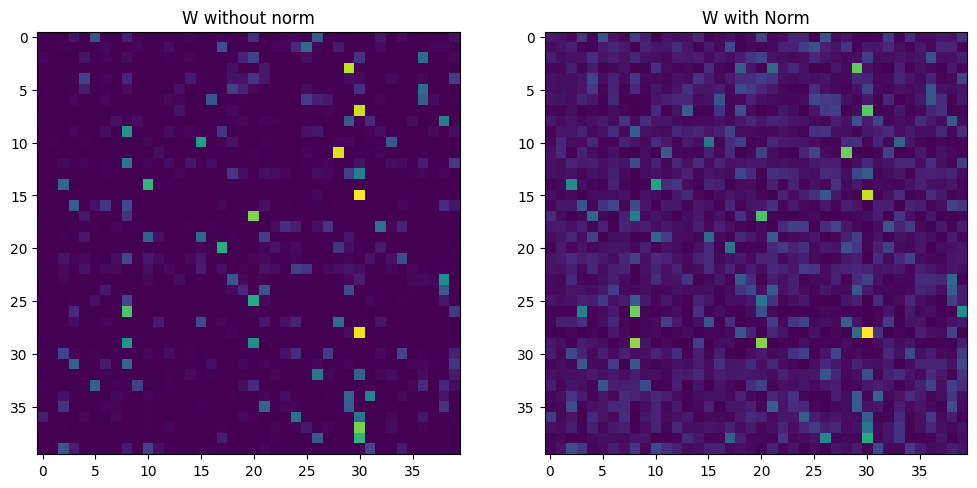

In [26]:
# In the transformer architecture the matrix W of size (context_size, context_size) is not a raw parameter,
# but rather the result of some computations.
# The matrix X_e, of size (context_size, emb_size) where each row is a token in the space of size emb_size
# is first projected  into a smaller space of size head_size. 
# This projection is a actually repeated three times to obtain matrices with different meanings:
#   - The rows of the matrix K represent the information with which a token should be indexed
#   - The rows of the matrix Q represent the information that a token is interested in
#   - The rows of the matrix V are projections of X_e that contains the info to be shareds
#
# When multiplying  matrix K of size (context_size, emb_size) and the transposse of Q
# of size (context_size, emb_size) we obtain a matrix of size (context_size, context_size)
# where the element at position (i,j) represents the amount of information that needs to be
# shared from token at position j to the token at position i.
# This matrix has the same shape and function as the matrix W discussed before.
# Adding a softmax operation we can obtain a matrix where each row is a probability distribution,
# and the element (i,j) gives us exactly the fraction of the token j that we want to transfer 
# to the token i.
#
# The last steps to perform is multilplying the self-attention matrix W by the input to operate the transfer 
# of information among tokens.
# This operation is performed in a space of size head_size, using the projected matrix V, 
# instead of the original matrix X_e.
#
#  The result of the attention mechanism is thus:
#   Z = softmax(Q x K.T) x V
#
#  The only detail remaining is the the normalization of the (Q x K.T) matrix to insure that the rows have unit variance.
#  If it's not the case (Q x K.T) might contain values that have large magnitude, and after applying the softmax
#  operation, the result will tend be a one-hot vector where only 1 or a few elemnts are different from zero,
#  while the otheres will be virtually zero.
#  Under this situation the attention mechanism will be greatly compromised, as a token will receive information
#  only from a handful of tokens in the context.
# Ex

context_size = 40
head_size = 10

# Generating Q and k
Q = torch.randn(context_size, head_size)
print(f'Q.shape = {Q.shape}')
K = torch.randn(context_size, head_size)
print(f'K.shape = {K.shape}')


# Multiplying the Q and K to obtain the W matrix
W = Q @ K.T
print(f'W.shape = {W.shape}')

# Normalizing with sqrt(head_size)
W_norm  = W / head_size**0.5

# Compting softmax of bot original and normalized
W_soft = W.softmax(axis=1)
W_norm_soft = W_norm.softmax(axis=1)

# Comparing the weight distribution with, and without normalization
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
ax0.set_title('W without norm')
ax0.imshow(W_soft)
ax1.set_title('W with Norm')
ax1.imshow(W_norm_soft)


'''
a = torch.randn(50,100)
print(a.std(axis= 1).mean())
b = torch.randn(50,100)
print(b.std(axis= 1).mean())
ab = (a @ b.T) 
print(ab.std(axis= 1).mean())
ab_norm = ab * 100**-0.5
print(ab_norm.std(axis= 1).mean())
'''

In [27]:
# Predicts next character using all previous characters

class TransformerLanguageModel(nn.Module):

    def __init__(self, vocab_size, emb_size, block_size, head_size):
        super().__init__()

        self.block_size = block_size

        # A table mapping the index of each character, to an embedding vector X_e_0 of size emb_size
        self.E = nn.Embedding(vocab_size, emb_size)

        # # A table mapping the position of each character, to an embedding vector X_e_1 of size emb_size
        self.P = nn.Embedding(block_size, emb_size)

        # The transformations mapping X_e to a space of size head_size.
        # X_e is a "private" representation of a token.
        # From this vector we can project different  representations
        #   - K => represents the information that X_e could provide (KEY)
        #   - Q => represents the information that X_e might require (QUERY)
        #   - V => represents the information that X_e will actually provide (VALUE)
        self.W_k = nn.Linear(emb_size, head_size)
        self.W_q = nn.Linear(emb_size, head_size)
        self.W_v = nn.Linear(emb_size, head_size)
        
        # Output layer to produce the logits
        self.output_layer = nn.Linear(head_size, vocab_size)
        

    def forward(self, X, y=None):

        # Transforming the input indices to embedding vectors
        # The shape of the input is (batch_size, block_size)
        # The shape of the output is (batch_size, block_size, emb_size)
        X_e_0 = self.E(X)

        # Transforming the input indices to embedding vectors
        # The shape of the input is (block_size)
        # The shape of the output is (block_size, emb_size)
        X_pos = torch.arange(0, self.block_size)  # creating matrix with positions: [0, 1, ...]
        X_e_1 = self.P(X_pos)   

        # Adding together the embedding vectors
        # The shape of X_e_0 is (batch_size, block_size, emb_size)
        # The shape of X_e_1 is  (block_size, emb_size)
        # (Broadcasting will make the operation possible)
        # The shape of the output is (batch_size, block_size, emb_size)
        X_e = X_e_0 + X_e_1


        # Projecting the embedding vector X_e to obtain K, Q, V in the space of size head_size
        K = self.W_k(X_e)
        Q = self.W_q(X_e)
        V = self.W_v(X_e)

        # Matrix providing the attention mechanism
        # - It is obtained comparing one by one, the rows of K with the rows of Q
        # - The scalar product between the i-th row of K and j-th row of Q represents
        #   the 'affinity' between the token at position i and the token at position j
        # - We divide by sqrt(emb_size) to ensure that the rows have unit variance
        # - We mask it with a triangular matrix to avoid contamination from tokens 
        #   in the future
        W  = torch.tril(Q @ K.transpose(1,2))  # we transpose only the last 2 dims. 1st dim is batch 
        W /= W.sum(axis=1, keepdims=True)
        W[W == 0.] = -torch.inf

        # Applying attention mechanism to get info from previous steps in the block
        # The mechanism is applied to the projection V
        X_a = W.softmax(axis=1) @ V
        
        # Extracting the logits of the next character, for each character in the input
        # The shape of the input is (batch_size, block_size, emb_size)
        # The shape of the output is (batch_size, block_size, vocab_size)
        logits = self.output_layer(X_a)

        # computing loss, only when a target y is provided
        if y is not None:
            # reshaping logits, and target to match the expected shapes of the cross_entropy function
            batch_size, block_size, vocab_size = logits.shape
            logits = logits.view((batch_size*block_size, vocab_size))
            y = y.view(batch_size*block_size)
            
            # computing the loss
            loss = F.cross_entropy(logits, y)
        else:
            loss = None

        return logits, loss

    def generate(self, X, max_length=100):

        # initilizing the result
        res = X.clone()

        for i in range(max_length):
            # performing a forward pass
            logits, loss = self.forward(X)
    
            # condsidering only the last character of each sequence
            logits = logits[:, -1, :]
    
            # computing probs, from the logits
            probs = logits.softmax(dim=-1)
    
            # sampling from the probability distributions
            new_element = torch.multinomial(probs, 1)
    
            # attaching the new elements to the context
            # and excluding the oldest element
            X = torch.concat((X[:, 1:], new_element), axis=1)

            # Storing the generated element
            res = torch.concat((res, new_element), axis=1)

        # Decoding the generated sequences
        res = [decode(res[i].tolist()) for i in range(res.shape[0]) ]

        return res

In [28]:
emb_size = 32
head_size = 16
m1 = TransformerLanguageModel(vocab_size, emb_size, block_size, head_size)
logits, loss = m1(x_train, y_train)
logits.shape, loss

(torch.Size([32, 65]), tensor(4.2762, grad_fn=<NllLossBackward0>))

In [30]:
# Training a model with Adam Optimizer
optimizer1 = torch.optim.Adam(m1.parameters(), lr=10**(-3))

print('TRAINING')
steps = 100000
for i in range(steps):

    # generating a random batch
    X_b, y_b = get_batch(data_train, batch_size, block_size, device)

    # forward pass
    logits, loss = m1(X_b, y_b)

    # bacward pass
    optimizer1.zero_grad(set_to_none=True)
    loss.backward()
    optimizer1.step()

    # printing at 10% intervals
    if i % int(steps / 10) == 0:
        print(loss.item())

print()
print('VALIDATION')
logits, loss = m1(X_val, y_val)
print(loss)

TRAINING
4.262965679168701
3.232572078704834
3.3648524284362793
3.1062920093536377
3.0491156578063965
2.8436172008514404
3.102666139602661
2.591468572616577
2.5304019451141357
2.7577946186065674

VALIDATION
tensor(2.7700, grad_fn=<NllLossBackward0>)


In [50]:
# Generating sequence from TRAINED model

# creating initial context
context = torch.zeros((1, block_size)).int()

# generating sequence of arbitrary length 
res = m1.generate(context, max_length=300)

print(res[0].strip())

QUENEN:
WThe fice tore.

NGOLDVO:
Mar thisal, lo byoull lillo to fromind acd wilis cous.
Whi theras?

Sany outournd ticomous cou?

ATher, wisto th anoug cere.
Bus,
H'se fris tyous gme?
And sded fusil t these?
CATheres:

Theeserer'd wis adsthe thereint akd'd ands omon;
D Buso mal byes th isad my arde


## Multi head attention

In [32]:
# class to represent a single attention head

class AttentionHead(nn.Module):
    
    def __init__(self, emb_size, head_size):
        super().__init__()
        
        # The transformations mapping X_e to a space of size head_size.
        # X_e is a "private" representation of a token.
        # From this vector we can project different  representations
        #   - K => represents the information that X_e could provide (KEY)
        #   - Q => represents the information that X_e might require (QUERY)
        #   - V => represents the information that X_e will actually provide (VALUE)
        self.W_k = nn.Linear(emb_size, head_size)
        self.W_q = nn.Linear(emb_size, head_size)
        self.W_v = nn.Linear(emb_size, head_size)

    
    def forward(self, X_e):

        # Getting device where data is residing
        device = X_e.device
        
        # Projecting the embedding vector X_e to obtain K, Q, V in the space of size head_size
        K = self.W_k(X_e)
        Q = self.W_q(X_e)
        V = self.W_v(X_e)

        # Matrix providing the attention mechanism
        # - It is obtained comparing one by one, the rows of K with the rows of Q
        # - The scalar product between the i-th row of K and j-th row of Q represents
        #   the 'affinity' between the token at position i and the token at position j
        # - We divide by sqrt(emb_size) to ensure that the rows have unit variance
        # - We mask it with a triangular matrix to avoid contamination from tokens 
        #   in the future
        W  = torch.tril(Q @ K.transpose(1,2)).to(device)  # we transpose only the last 2 dims. 1st dim is batch 
        W /= W.sum(axis=1, keepdims=True)
        W[W == 0.] = -torch.inf

        # Applying attention mechanism to get info from previous steps in the block
        # The mechanism is applied to the projection V
        X_a = W.softmax(axis=1) @ V
        
        return X_a

        

In [33]:
torch.tril(torch.ones((3,3))).to(device)

tensor([[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]])

In [34]:
ah = AttentionHead(30, 10)
a = torch.randn((32, 200, 30))
ah(a).shape

torch.Size([32, 200, 10])

In [40]:
# class to represent multiple attention heads applied in parallel

class MultiAttentionHead(nn.Module):
    
    def __init__(self, heads_number, emb_size, head_size, ):
        super().__init__()

        # Initializing heads_number attention heads
        self.heads = nn.ModuleList([AttentionHead(emb_size, head_size) for i in range(heads_number)])
        
    
    def forward(self, X_e):

        # Applying the attention heads separately, and concatenating the results
        X_ma = torch.concat([ah(X_e) for ah in self.heads], axis=-1)
        
        return X_ma

    '''
    def to(device):
        new_self = super(MultiAttentionHead, self).to(device)
        new_self.heads = [ah.to(device) for ah in new_self.heads]
    
        return new_self
    '''
        

In [42]:
ah = MultiAttentionHead(5, 30, 10)
a = torch.randn((32, 200, 30))
ah(a).shape

torch.Size([32, 200, 50])

In [45]:
# Predicts next character using all previous characters
# Uses multiple attention heads

class MultiHeadTransformerLanguageModel(nn.Module):

    def __init__(self, vocab_size, emb_size, block_size, head_size, heads_numbers):
        super().__init__()

        self.block_size = block_size

        # A table mapping the index of each character, to an embedding vector X_e_0 of size emb_size
        self.E = nn.Embedding(vocab_size, emb_size)

        # # A table mapping the position of each character, to an embedding vector X_e_1 of size emb_size
        self.P = nn.Embedding(block_size, emb_size)

        # The multi-head attention  block
        self.MAH = MultiAttentionHead(heads_numbers, emb_size, head_size)
        
        # Output layer to produce the logits
        self.output_layer = nn.Linear(head_size*heads_numbers, vocab_size)
        

    def forward(self, X, y=None):

        # Getting device where data is residing
        device = X.device
        
        # Transforming the input indices to embedding vectors
        # The shape of the input is (batch_size, block_size)
        # The shape of the output is (batch_size, block_size, emb_size)
        X_e_0 = self.E(X)

        # Transforming the input indices to embedding vectors
        # The shape of the input is (block_size)
        # The shape of the output is (block_size, emb_size)
        X_pos = torch.arange(0, self.block_size, device=device)  # creating matrix with positions: [0, 1, ...]
        X_e_1 = self.P(X_pos)   

        # Adding together the embedding vectors
        # The shape of X_e_0 is (batch_size, block_size, emb_size)
        # The shape of X_e_1 is  (block_size, emb_size)
        # (Broadcasting will make the operation possible)
        # The shape of the output is (batch_size, block_size, emb_size)
        X_e = X_e_0 + X_e_1

        # Applying the multiple attention heads 
        X_a = self.MAH(X_e)
        
        # Extracting the logits of the next character, for each character in the input
        # The shape of the input is (batch_size, block_size, emb_size)
        # The shape of the output is (batch_size, block_size, vocab_size)
        logits = self.output_layer(X_a)

        # computing loss, only when a target y is provided
        if y is not None:
            # reshaping logits, and target to match the expected shapes of the cross_entropy function
            batch_size, block_size, vocab_size = logits.shape
            logits = logits.view((batch_size*block_size, vocab_size))
            y = y.view(batch_size*block_size)
            
            # computing the loss
            loss = F.cross_entropy(logits, y)
        else:
            loss = None

        return logits, loss

    def generate(self, X, max_length=100):

        # initilizing the result
        res = X.clone()

        for i in range(max_length):
            # performing a forward pass
            logits, loss = self.forward(X)
    
            # condsidering only the last character of each sequence
            logits = logits[:, -1, :]
    
            # computing probs, from the logits
            probs = logits.softmax(dim=-1)
    
            # sampling from the probability distributions
            new_element = torch.multinomial(probs, 1)
    
            # attaching the new elements to the context
            # and excluding the oldest element
            X = torch.concat((X[:, 1:], new_element), axis=1)

            # Storing the generated element
            res = torch.concat((res, new_element), axis=1)

        # Decoding the generated sequences
        res = [decode(res[i].tolist()) for i in range(res.shape[0]) ]

        return res

In [46]:
x_train.shape

torch.Size([4, 8])

In [47]:

#device = torch.device("mps")
emb_size = 32
head_size = 8
head_numbers = 4
m2 = MultiHeadTransformerLanguageModel(vocab_size, emb_size, block_size, head_size, head_numbers)
m2.to(device)
logits, loss = m2(x_train, y_train)
logits.shape, loss

(torch.Size([32, 65]), tensor(4.2218, grad_fn=<NllLossBackward0>))

In [48]:
%%time

# Training a model with Adam Optimizer
optimizer2 = torch.optim.Adam(m2.parameters(), lr=10**(-3))

print('TRAINING')
steps = 100000
for i in range(steps):

    # generating a random batch
    #X_b, y_b = get_batch(data_train, batch_size, block_size, device)
    X_b, y_b = get_batch(data_train, batch_size, block_size, device)
    
    # forward pass
    logits, loss = m2(X_b, y_b)

    # bacward pass
    optimizer2.zero_grad(set_to_none=True)
    loss.backward()
    optimizer2.step()

    # printing at 10% intervals
    if i % int(steps / 10) == 0:
        print(loss.item())

print()
print('VALIDATION')
logits, loss = m2(X_val, y_val)
print(loss)

TRAINING
4.2646565437316895
2.7620913982391357
2.6786835193634033
2.490812063217163
2.955991744995117
2.7675678730010986
3.134674310684204
2.7351832389831543
3.260215997695923
2.4945969581604004

VALIDATION
tensor(2.8049, grad_fn=<NllLossBackward0>)
CPU times: user 9min 15s, sys: 12min 32s, total: 21min 48s
Wall time: 2min 51s


In [51]:
# Generating sequence from TRAINED model

# creating initial context
context = torch.zeros((1, block_size)).int()

# generating sequence of arbitrary length 
res = m2.generate(context, max_length=300)

print(res[0].strip())

QUENSES:
Torowe ko ndo, wto n the,
Wy isfroud;
I''s spallll.
I l Iwol, y aks corme ascuplo bll, alllll.
KI I Od I Iw thals anst.
Th alilds halpot,
Thes akan hy teras;
Tin hart mis.
LI'd I this sto thing mit'ss th.
An t hadd bire tong ghar?
Cisin,
Cand alss?
NGo forore bus cecore?
Mrom lblones,
To co


# Multiple decoder layers


In [52]:
# Generalizing the architecture to have multiple decoder layers.
# Each decoder layer is composed of :
#   - a multiattention head
#   - a fully connected feed forward layer
#   - ...


In [53]:
# Fully connected neural network transforming embed_size feature in new embed_size features.
# The main diferrence between the attention block and the feed forward block are that:
#   - the attention layer performs data transformation in the time dimension, by looking updating
#     each feature of a token, by looking at the values of the same feature for tokens that apperead
#     at previous times.
#   - the feed forward layer creating new features for a given token by combining all the features of the same token,
#     and without using any info from other token.
#
# The feed forward networks create new embed_size features in the following way:
#  - create new K * embed_size features with a MLP
#  - projects the K * embed_size into embed_size with a linear transformation

class FeedForward(nn.Module):

    def __init__(self, emb_size, K=4):
        super().__init__()
        self.W1 = nn.Linear(emb_size, K * emb_size)
        self.R = nn.ReLU()
        self.W2 = nn.Linear(K * emb_size, emb_size)

    def forward(self, X):
        # applying:
        #  - linear transformation
        #  - non linearity
        #  - linear transformation
        return self.W2(self.R(self.W1(X)))
    

In [54]:
x = torch.randn((32, 20, 10))
ff = FeedForward(10)
ff(x).shape

torch.Size([32, 20, 10])

In [55]:
class EncoderLayer(nn.Module):

    def __init__(self, heads_numbers, emb_size, head_size):
        super().__init__()
        
        # The multi-head attention  block
        self.MAH = MultiAttentionHead(heads_numbers, emb_size, head_size)

        # The layer normalization for the outputs of the attention block
        self.LN1 = nn.LayerNorm([emb_size])

        # The feed forward layer
        self.FF = FeedForward(emb_size)

        # The layer normalization for the outputs of the attention block
        self.LN2 = nn.LayerNorm([emb_size])

    def forward(self, X):
        
        # Sharing informtion between tokens:
        X_a = self.MAH(X)
        # Normalizing so that the varince of each token is 1
        X_a = self.LN1(X_a)
        # Adding skip connection
        X_a = X_a + X
        
        # Sharing information between the components of each token
        X_f = self.FF(X_a)
        # Normalizing so that the varince of each token is 1
        X_f = self.LN2(X_f)
        # Adding skip connection
        X_f = X_f + X_a
            
        return X_f
    

In [56]:
x = torch.randn((32, 20, 30))
el = EncoderLayer(3, 30, 10)
y = el(x)
y.shape

torch.Size([32, 20, 30])

In [57]:
x = torch.randint(13, (32, 20, 30)).float()
print([x.std(axis=i).mean() for i in range(3)])
W = torch.randn(30, 50)
x1 = x @ W
print([x1.std(axis=i).mean() for i in range(3)])
LN = nn.LayerNorm([50])
y = LN(x1)
print([y.std(axis=i).mean() for i in range(3)] )

[tensor(3.7305), tensor(3.7253), tensor(3.7247)]
[tensor(19.9721), tensor(19.9255), tensor(41.8956)]
[tensor(0.4655, grad_fn=<MeanBackward0>), tensor(0.4643, grad_fn=<MeanBackward0>), tensor(1.0102, grad_fn=<MeanBackward0>)]


In [58]:
# Predicts next character using all previous characters
# Uses multiple encoder layers

class MultiEncoderLayersLanguageModel(nn.Module):

    def __init__(self, layers_number, vocab_size, emb_size, block_size, head_size, heads_number):
        super().__init__()

        self.block_size = block_size

        # A table mapping the index of each character, to an embedding vector X_e_0 of size emb_size
        self.E = nn.Embedding(vocab_size, emb_size)

        # A table mapping the position of each character, to an embedding vector X_e_1 of size emb_size
        self.P = nn.Embedding(block_size, emb_size)

        # The encoder layers
        self.EL = nn.Sequential(*[EncoderLayer(heads_number, emb_size, head_size) 
                                 for i in range(layers_number)])

        # The layer normalization to apply before the last layer
        self.LN = nn.LayerNorm([head_size*heads_number])
        
        # Output layer to produce the logits
        self.output_layer = nn.Linear(head_size*heads_number, vocab_size)
        

    def forward(self, X, y=None):

        # Getting device where data is residing
        device = X.device
        
        # Transforming the input indices to embedding vectors
        # The shape of the input is (batch_size, block_size)
        # The shape of the output is (batch_size, block_size, emb_size)
        X_e_0 = self.E(X)

        # Transforming the input indices to embedding vectors
        # The shape of the input is (block_size)
        # The shape of the output is (block_size, emb_size)
        X_pos = torch.arange(0, self.block_size, device=device)  # creating matrix with positions: [0, 1, ...]
        X_e_1 = self.P(X_pos)   

        # Adding together the embedding vectors
        # The shape of X_e_0 is (batch_size, block_size, emb_size)
        # The shape of X_e_1 is  (block_size, emb_size)
        # (Broadcasting will make the operation possible)
        # The shape of the output is (batch_size, block_size, emb_size)
        X_e = X_e_0 + X_e_1

        # Applying the encoder layers
        X_a = self.EL(X_e)

        # Applying the layer normalization
        X_a = self.LN(X_a)
        
        # Extracting the logits of the next character, for each character in the input
        # The shape of the input is (batch_size, block_size, emb_size)
        # The shape of the output is (batch_size, block_size, vocab_size)
        logits = self.output_layer(X_a)

        # computing loss, only when a target y is provided
        if y is not None:
            # reshaping logits, and target to match the expected shapes of the cross_entropy function
            batch_size, block_size, vocab_size = logits.shape
            logits = logits.view((batch_size*block_size, vocab_size))
            y = y.view(batch_size*block_size)
            
            # computing the loss
            loss = F.cross_entropy(logits, y)
        else:
            loss = None

        return logits, loss

    def generate(self, X, max_length=100):

        # initilizing the result
        res = X.clone()

        for i in range(max_length):
            # performing a forward pass
            logits, loss = self.forward(X)
    
            # condsidering only the last character of each sequence
            logits = logits[:, -1, :]
    
            # computing probs, from the logits
            probs = logits.softmax(dim=-1)
    
            # sampling from the probability distributions
            new_element = torch.multinomial(probs, 1)
    
            # attaching the new elements to the context
            # and excluding the oldest element
            X = torch.concat((X[:, 1:], new_element), axis=1)

            # Storing the generated element
            res = torch.concat((res, new_element), axis=1)

        # Decoding the generated sequences
        res = [decode(res[i].tolist()) for i in range(res.shape[0]) ]

        return res

## 1 layer

In [59]:
emb_size = 32
head_size = 8
head_numbers = 4
m3 = MultiEncoderLayersLanguageModel(1, vocab_size, emb_size, block_size, head_size, head_numbers)
m3.to(device)
logits, loss = m3(x_train, y_train)
logits.shape, loss

(torch.Size([32, 65]), tensor(4.2525, grad_fn=<NllLossBackward0>))

In [60]:
%%time

# Training a model with Adam Optimizer
optimizer3 = torch.optim.Adam(m3.parameters(), lr=10**(-3))

print('TRAINING')
steps = 100000
for i in range(steps):

    # generating a random batch
    #X_b, y_b = get_batch(data_train, batch_size, block_size, device)
    X_b, y_b = get_batch(data_train, batch_size, block_size, device)
    
    # forward pass
    logits, loss = m3(X_b, y_b)

    # bacward pass
    optimizer3.zero_grad(set_to_none=True)
    loss.backward()
    optimizer3.step()

    # printing at 10% intervals
    if i % int(steps / 10) == 0:
        print(loss.item())

print()
print('VALIDATION')
logits, loss = m3(X_val, y_val)
print(loss)

TRAINING
4.5573039054870605
2.4879300594329834
2.2736194133758545
1.884597659111023
2.193108320236206
2.0519917011260986
2.158106565475464
2.104804277420044
1.7611197233200073
2.0642142295837402

VALIDATION
tensor(2.0711, grad_fn=<NllLossBackward0>)
CPU times: user 11min 41s, sys: 15min 22s, total: 27min 3s
Wall time: 3min 29s


In [61]:
# Generating sequence from TRAINED model

# creating initial context
context = torch.zeros((1, block_size)).int()

# generating sequence of arbitrary length 
res = m3.generate(context, max_length=300)

print(res[0].strip())

BUCLESLI:
Plarst.

RICCATHANLANE:
Werwill de.

CARBUTIO:
By O hane,
Whe andess call ath pis.

My'so Cak o blin fig Reast, fth, o.

RIV:
By Geart nodll't bot atherle w hard id na f iredecl comehof h fricomblese,
That plouring ibesin com jonssecturt be hear?
SICELKIABONVELIUCET:
Dn py haf f youlcedes;


## 2 layers

In [62]:
emb_size = 32
head_size = 8
head_numbers = 4
m4 = MultiEncoderLayersLanguageModel(2, vocab_size, emb_size, block_size, head_size, head_numbers)
m4.to(device)
logits, loss = m4(x_train, y_train)
logits.shape, loss

(torch.Size([32, 65]), tensor(4.3400, grad_fn=<NllLossBackward0>))

In [63]:
%%time

# Training a model with Adam Optimizer
optimizer4 = torch.optim.Adam(m4.parameters(), lr=10**(-3))

print('TRAINING')
steps = 100000
for i in range(steps):

    # generating a random batch
    #X_b, y_b = get_batch(data_train, batch_size, block_size, device)
    X_b, y_b = get_batch(data_train, batch_size, block_size, device)
    
    # forward pass
    logits, loss = m4(X_b, y_b)

    # bacward pass
    optimizer4.zero_grad(set_to_none=True)
    loss.backward()
    optimizer4.step()

    # printing at 10% intervals
    if i % int(steps / 10) == 0:
        print(loss.item())

print()
print('VALIDATION')
logits, loss = m4(X_val, y_val)
print(loss)

TRAINING
4.531033039093018
1.9015980958938599
2.156529664993286
2.5381391048431396
1.8989261388778687
2.076533079147339
1.9867684841156006
1.7173433303833008
1.571828842163086
1.8651556968688965

VALIDATION
tensor(1.6103, grad_fn=<NllLossBackward0>)
CPU times: user 22min 29s, sys: 29min 41s, total: 52min 11s
Wall time: 6min 44s


In [66]:
# Generating sequence from TRAINED model

# creating initial context
context = torch.zeros((1, block_size)).int()

# generating sequence of arbitrary length 
res = m4.generate(context, max_length=300)

print(res[0].strip())

COFING VICENSA:
God rair.

Mut Mord got
Bule,
VNE I ther, so.

Pin it of bease heans
Thice our s pyet.

Fo wild no?
DUSES:
Amy stak Momm grong wit astent Wutiiot.

JAl, beait I mor los wingy?

Roy'l nie.

COF IY gral hith whil To now's
M:
My to dome not, to me. horre?
Saur grout Yor A.

ESINE:
My I
